In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import datetime as dtm
import dateutil.parser as dparser
import vel_tools as vt

from salishsea_tools import nc_tools, viz_tools

%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

In [2]:
def format_plot(ax, xlim=None, ylim=None, xticks=None, yticks=None, xlabel=None, ylabel=None, title=None):
    '''Simplifies formatting code for plots
    '''
    
    if xlim   is not None: ax.set_xlim(xlim)
    if ylim   is not None: ax.set_ylim(ylim)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title  is not None: ax.set_title(title)

In [14]:
def make_plots(datein, t=[0], zlevel=[0], ylocn=455, section_slice=np.arange(238, 318),
               map_bounds=(-124, -123, 48.5, 49.7)):
    '''Plot nowcast and nowcast-green velocity fields
    '''
    
    # Version
    version = 3.6
    
    # ----- LOAD GEM FORCING AND NEMO RESULTS -----
    GEM_OP = vt.load_atmos(datein)
    u_vel, v_vel, w_vel, tracers = vt.load_nowcast(datein, version=version, avg='h')
    PA_NEMO = vt.load_nowcast_station(datein, version=version, station_name='PointAtkinson')
    VI_NEMO = vt.load_nowcast_station(datein, version=version, station_name='Victoria')
    
    # ----- GET DATETIME ARRAYS -----
    time_GEM     = vt.get_datetimes(GEM_OP)
    time_grid    = vt.get_datetimes(u_vel)
    time_station = vt.get_datetimes(PA_NEMO)
    
    # ----- DEFINE SUBFIELDS -----
    lon_GEM  = GEM_OP.variables['nav_lon']   # GEM longitude            [deg   0 to 360]
    lat_GEM  = GEM_OP.variables['nav_lat']   # GEM latitude             [deg -90 to  90]
    lon_NEMO = u_vel.variables[ 'nav_lon']   # NEMO longitude           [deg   0 to 360]
    lat_NEMO = u_vel.variables[ 'nav_lat']   # NEMO latitude            [deg -90 to  90]
    zlevels  = u_vel.variables[ 'depthu' ]   # NEMO zlevels             [m]
    u_wind   = GEM_OP.variables['u_wind' ]   # Zonal 10m windspeed      [m/s]
    v_wind   = GEM_OP.variables['v_wind' ]   # Meridional 10m windspeed [m/s]
    u_grid   = u_vel.variables[ 'vozocrtx']  # Cross-strait velocity    [m/s]
    v_grid   = v_vel.variables[ 'vomecrty']  # Along-strait velocity    [m/s]

    # ----- MAKE PLOTS -----
    fig, ax = plt.subplots(1, 6, figsize=(15, 20))
    gs = mpl.gridspec.GridSpec(4, 3, width_ratios=[2.3, 1, 1], height_ratios=[1, 1, 1.5, .45])
    ax[0] = plt.subplot(gs[:2 , 0 ])
    ax[1] = plt.subplot(gs[ 0 , 1:])
    ax[2] = plt.subplot(gs[ 1 , 1:])
    ax[3] = plt.subplot(gs[ 2:, 0 ])
    ax[4] = plt.subplot(gs[ 2 , 1 ])
    ax[5] = plt.subplot(gs[ 2 , 2 ])
    
    # ----- PLOT SURFACE CURRENTS -----
    vt.make_grid(ax[0])
    Q1 = vt.plot_horz_currents(ax[0], lon_NEMO, lat_NEMO, u_grid, v_grid, t=t, zlevel=zlevel, detide=False)
    Q2 = vt.plot_wind(ax[0], lon_GEM, lat_GEM, u_wind, v_wind, t=t)
    ax[0].add_patch(mpl.patches.Rectangle((-124, 49.53), 0.2, 0.17, facecolor='white'))
    plt.quiverkey(Q1, 0.1, 0.93, 1, '1 m/s')
    plt.quiverkey(Q2, 0.1, 0.87, 1, '1 m/s')
    ax[0].plot(lon_NEMO[ylocn, section_slice], lat_NEMO[ylocn, section_slice],
                  linestyle='solid', linewidth=3, color='black', label='Section Line')
    ax[0].plot(lon_NEMO[416, 283], lat_NEMO[416, 283], 'ko', markersize=8, label='ONC East')
    ax[0].plot(lon_NEMO[424, 266], lat_NEMO[424, 266], 'ko', markersize=8, label='ONC Central')
    ax[0].plot(-123.27, 49.33, 'ko', markersize=8, label='Point Atkinson')
    format_plot(ax[0], xlim  = map_bounds[0:2],
                       ylim  = map_bounds[2:4],
                       title = 'NEMO {:.1f} surface currents, GEM HRDPS 10m winds'.format(version))
    
    # ----- PLOT ALONGSHORE CURRENTS -----
    mesh = vt.plot_cross_section(ax[3], lon_NEMO, v_grid, zlevels, ylocn, section_slice, t=t, crange=(-.5, .5))
    ax[3].plot(np.array([lon_NEMO[416, 283], lon_NEMO[416, 283]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC East')
    ax[3].plot(np.array([lon_NEMO[424, 266], lon_NEMO[424, 266]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC Central')
    cbar = fig.colorbar(mesh, ax=ax[3], orientation='horizontal')
    cbar.set_ticks(np.arange(-.5, .501, .1))
    cbar.set_label('Alongstrait Velocity [m/s]')
    format_plot(ax[3], xlim   = [-123.55, -123.25],
                       ylim   = [400, 0],
                       xticks = np.arange(-123.5, -123.3, 0.1),
                       ylabel = 'Depth [m]')
        
    # Plot Point Atkinson SSH
    ax[1].plot(time_station, PA_NEMO.variables['sossheig'][:, 0, 0], 'k-')
    ax[1].plot(time_station[t[0]*4], PA_NEMO.variables['sossheig'][t[0]*4, 0, 0], 'ko', markersize=12)
    ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    ax[1].annotate('{}'.format(time_grid[t[0]].strftime('%Y-%b-%d %H:%M')), xy=(.7, .05), xycoords='axes fraction')
    format_plot(ax[1], ylim  = [-2.5, 2.5],
                       title = 'NEMO SSH [m] at Point Atkinson')
    
    # Plot Victoria SSH
    ax[2].plot(time_station, VI_NEMO.variables['sossheig'][:, 0, 0], 'k-')
    ax[2].plot(time_station[t[0]*4], VI_NEMO.variables['sossheig'][t[0]*4, 0, 0], 'ko', markersize=12)
    ax[2].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    format_plot(ax[2], ylim  = [-2.5, 2.5],
                       title = 'NEMO SSH [m] at Victoria')
    
    # Plot ONC central node comparison
    vt.plot_ONC_comparisons(ax[4], datein, 'central', u_grid, v_grid, zlevels, t=t)
    format_plot(ax[4], xlim   = [-.5, .5],
                       ylim   = [400, 0],
                       xlabel = 'Alongstrait Velocity [m/s]',
                       title  = 'ONC Central Node')
    
    # Plot ONC east node comparison
    vt.plot_ONC_comparisons(ax[5], datein, 'east', u_grid, v_grid, zlevels, t=t)
    ax[5].legend(['NEMO', 'ONC'], loc=4)
    format_plot(ax[5], xlim   = [-.5, .5],
                       ylim   = [400, 0],
                       xlabel = 'Alongstrait Velocity [m/s]',
                       title  = 'ONC East Node')

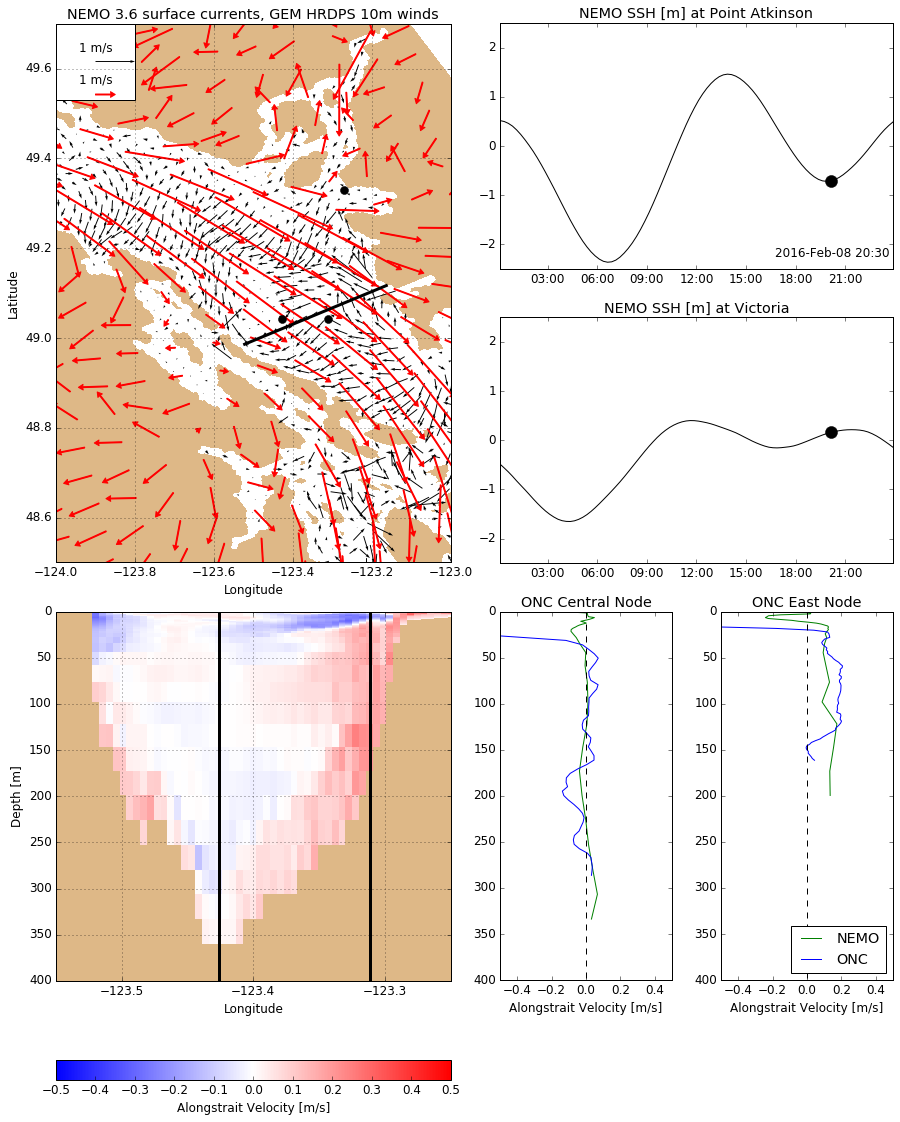

In [15]:
# Plotting parameters
# ------ T = 0 ----------
t             = [20]
zlevel        = [0]
ylocn         = 420
section_slice = np.arange(245, 315)
map_bounds    = (-124, -123, 48.5, 49.7)

# Make Plots
make_plots('2016 feb 08', t=t, zlevel=zlevel, ylocn=ylocn, section_slice=section_slice, map_bounds=map_bounds)

#plt.savefig('NEMO_currents.eps', bbox_inches='tight')

In [3]:
def make_plots_detide(datein, t=[0], zlevel=[0], map_bounds=(-124, -123, 48.5, 49.7)):
    '''Plot nowcast and nowcast-green velocity fields
    '''
    
    # Version
    version = 3.6
    
    # ----- LOAD GEM FORCING AND NEMO RESULTS -----
    GEM_OP = vt.load_atmos(datein)
    u_vel, v_vel, w_vel, tracers = vt.load_nowcast(datein, version=version, avg='h')
    
    # ----- GET DATETIME ARRAYS -----
    time_GEM     = vt.get_datetimes(GEM_OP)
    time_grid    = vt.get_datetimes(u_vel)
    
    # ----- DEFINE SUBFIELDS -----
    lon_GEM  = GEM_OP.variables['nav_lon']   # GEM longitude            [deg   0 to 360]
    lat_GEM  = GEM_OP.variables['nav_lat']   # GEM latitude             [deg -90 to  90]
    lon_NEMO = u_vel.variables[ 'nav_lon']   # NEMO longitude           [deg   0 to 360]
    lat_NEMO = u_vel.variables[ 'nav_lat']   # NEMO latitude            [deg -90 to  90]
    zlevels  = u_vel.variables[ 'depthu' ]   # NEMO zlevels             [m]
    u_wind   = GEM_OP.variables['u_wind' ]   # Zonal 10m windspeed      [m/s]
    v_wind   = GEM_OP.variables['v_wind' ]   # Meridional 10m windspeed [m/s]
    u_grid   = u_vel.variables[ 'vozocrtx']  # Cross-strait velocity    [m/s]
    v_grid   = v_vel.variables[ 'vomecrty']  # Along-strait velocity    [m/s]

    # ----- MAKE PLOTS -----
    fig, ax = plt.subplots(2, 3, figsize=(15, 13))
    
    # ----- PLOT SURFACE CURRENTS -----
    for col, time in enumerate(np.array([0, 10, 20])):
        for row in np.array([0, 1]):
            vt.make_grid(ax[row, col])
            Q1 = vt.plot_horz_currents(ax[row, col], lon_NEMO, lat_NEMO, u_grid, v_grid, t=[time],
                                       zlevel=zlevel, detide=bool(row))
            Q2 = vt.plot_wind(ax[row, col], lon_GEM, lat_GEM, u_wind, v_wind, t=[time])
            ax[row, col].add_patch(mpl.patches.Rectangle((-124, 49.53), 0.2, 0.17, facecolor='white'))
            plt.quiverkey(Q1, 0.1, 0.93, 1, '1 m/s')
            plt.quiverkey(Q2, 0.1, 0.87, 1, '1 m/s')
            format_plot(ax[row, col], xlim  = map_bounds[0:2],
                                      ylim  = map_bounds[2:4])
    


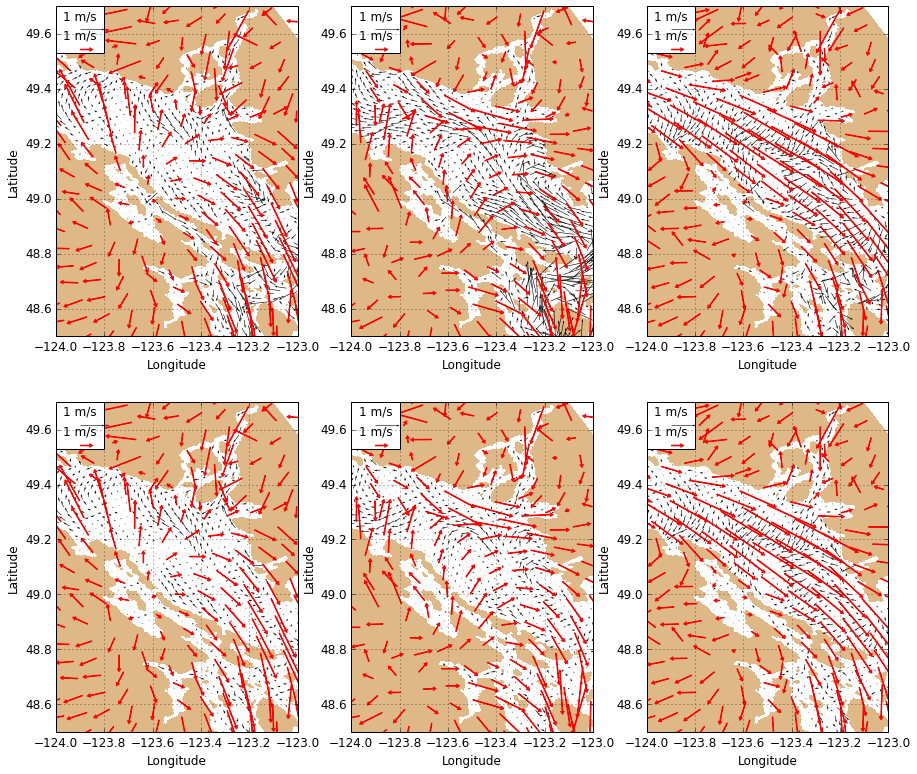

In [4]:
# Plotting parameters
# ------ T = 0 ----------
t             = [0]
zlevel        = [0]
map_bounds    = (-124, -123, 48.5, 49.7)

# Make Plots
make_plots_detide('2016 feb 08', t=t, zlevel=zlevel, map_bounds=map_bounds)